In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [19]:
ds = load_dataset("microsoft/cats_vs_dogs", split='train')

In [20]:
print(ds)

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


In [21]:
ds.shape

(23410, 2)

In [50]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'labels': 0}

In [51]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
    }

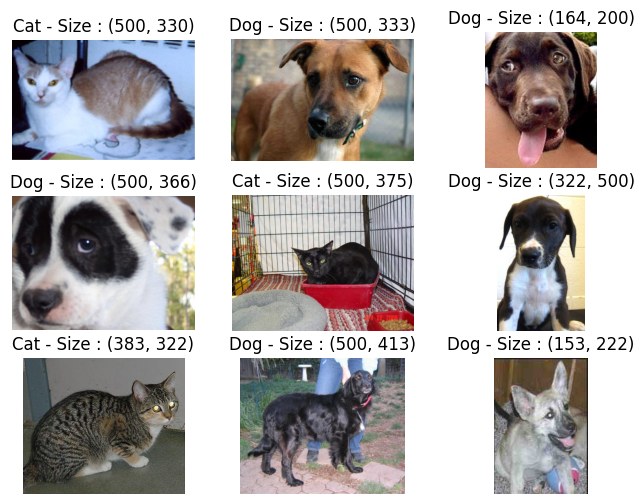

In [ ]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
}

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
ax = ax.flatten()

for i in range(9):
    randomInt = np.random.randint(ds.shape[0])
    ax[i].set_title(f"{label_catdogs[ds[randomInt]['labels']]} - Size : {ds[randomInt]['image'].size}")
    ax[i].axis("off")
    ax[i].imshow(ds[randomInt]["image"])
    
plt.axis("off")
plt.show()

In [79]:
images_sizes = [ds[i]['image'].size for i in range(ds.shape[0])]

In [82]:
widths, heights = zip(*images_sizes)

average_width, average_height = int(sum(widths) / len(widths)), int(sum(heights) / len(heights))

print(f"Average size of the images from the dataset is {average_width, average_height}")

Average size of the images from the dataset is (409, 364)
